 # Deep Q Networks

 ## Imports

In [1]:
import gym, random, pickle, os.path, math, glob
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta
from timeit import default_timer as timer

import torch
import torch.optim as optim

import matplotlib
%matplotlib inline
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from utils.wrappers import *
from utils.hyperparameters import Config
from utils.plot import plot_all_data

from agents.BaseAgent import BaseAgent


 # Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#epsilon variables
config.epsilon_start    = 1.0
config.epsilon_final    = 0.01
config.epsilon_decay    = 30000
config.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

#misc agent variables
config.GAMMA = 0.99
config.LR    = 1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE        = 100000
config.BATCH_SIZE             = 32

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES  = 1000000
config.UPDATE_FREQ = 1

#data logging parameters
config.ACTION_SELECTION_COUNT_FREQUENCY = 1000

# bootstapped parameters
config.NUM_HEADS = 20
config.BERNOULLI_P = 0.8

 ## Replay Memory

In [3]:
class ExperienceReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size), None, None

    def __len__(self):
        return len(self.memory)


 ## Network Declaration

In [4]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.conv1 = nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.bootstrapped_heads = nn.ModuleList([nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)) for k in range(config.NUM_HEADS)])
        
    def forward(self, x):
        outputs = []
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
    
        for idx in range(config.NUM_HEADS):
            outputs.append(self.bootstrapped_heads[idx](x))
        return outputs
    
    def feature_size(self):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *self.input_shape)))).view(1, -1).size(1)


 ## Agent

In [5]:
class Model(BaseAgent):
    def __init__(self, static_policy=False, env=None, config=None, log_dir='/tmp/gym'):
        super(Model, self).__init__(config=config, env=env, log_dir=log_dir)
        self.device = config.device

        self.gamma = config.GAMMA
        self.lr = config.LR
        self.target_net_update_freq = config.TARGET_NET_UPDATE_FREQ
        self.experience_replay_size = config.EXP_REPLAY_SIZE
        self.batch_size = config.BATCH_SIZE
        self.learn_start = config.LEARN_START
        self.update_freq = config.UPDATE_FREQ

        self.static_policy = static_policy
        self.num_feats = env.observation_space.shape
        self.num_actions = env.action_space.n
        self.env = env

        self.declare_networks()
            
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        #move to correct device
        self.model = self.model.to(self.device)
        self.target_model.to(self.device)

        if self.static_policy:
            self.model.eval()
            self.target_model.eval()
        else:
            self.model.train()
            self.target_model.train()

        self.update_count = 0

        self.declare_memory()

    def declare_networks(self):
        self.model = DQN(self.num_feats, self.num_actions)
        self.target_model = DQN(self.num_feats, self.num_actions)

    def declare_memory(self):
        self.memory = ExperienceReplayMemory(self.experience_replay_size)

    def append_to_replay(self, s, a, r, s_, m):
        self.memory.push((s, a, r, s_, m))

    def prep_minibatch(self):
        # random transition batch is taken from experience replay memory
        transitions, indices, weights = self.memory.sample(self.batch_size)
        
        batch_state, batch_action, batch_reward, batch_next_state, batch_masks = zip(*transitions)

        shape = (-1,)+self.num_feats

        batch_state = torch.tensor(batch_state, device=self.device, dtype=torch.float).view(shape)
        batch_action = torch.tensor(batch_action, device=self.device, dtype=torch.long).squeeze().view(-1, 1)
        batch_reward = torch.tensor(batch_reward, device=self.device, dtype=torch.float).squeeze().view(-1, 1)
        batch_masks = torch.tensor(batch_masks, device=self.device, dtype=torch.float)
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=self.device, dtype=torch.bool)
        try: #sometimes all next states are false
            non_final_next_states = torch.tensor([s for s in batch_next_state if s is not None], device=self.device, dtype=torch.float).view(shape)
            empty_next_state_values = False
        except:
            non_final_next_states = None
            empty_next_state_values = True

        return batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, batch_masks, indices, weights

    def compute_loss(self, batch_vars):
        cpu_loss = 0
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, batch_masks, indices, weights = batch_vars
        
        head_current_q_values = []
        for t in self.model(batch_state):
            head_current_q_values.append(t.gather(1, batch_action))

        head_expected_q_values = []
        with torch.no_grad():
            max_next_q_values = torch.zeros((self.batch_size,config.NUM_HEADS), device=self.device, dtype=torch.float).unsqueeze(dim=2)
            if not empty_next_state_values:
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                max_next_q_values[non_final_mask] = torch.stack(self.target_model(non_final_next_states),dim=1)\
                    .gather(2, max_next_action.unsqueeze(dim=2))
                for max_next_q in list(max_next_q_values.unbind(dim=1)):
                    expected_q_values = batch_reward + self.gamma*max_next_q
                    head_expected_q_values.append(expected_q_values)

                    
        self.optimizer.zero_grad()
        
        for i in range(config.NUM_HEADS):
            loss = (head_current_q_values[i] - head_expected_q_values[i]) ** 2
            loss = (1. / config.NUM_HEADS) *(batch_masks[:, i] * loss).mean()
            loss.backward(retain_graph=True)
            cpu_loss += loss.detach().cpu().numpy()
            
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        
        return cpu_loss /config.NUM_HEADS

    def update(self, s, a, r, s_, m, frame=0):
        if self.static_policy:
            return None

        self.append_to_replay(s, a, r, s_, m)

        if frame < self.learn_start or frame % self.update_freq != 0:
            return None

        batch_vars = self.prep_minibatch()

        loss = self.compute_loss(batch_vars)

        # Optimize the model
        self.optimizer.step()

        self.update_target_model()
        self.save_td(loss.item(), frame)
        self.save_sigma_param_magnitudes(frame)

    def get_action(self, s, eps=0.1):
        with torch.no_grad():
            if np.random.random() >= eps or self.static_policy:
                X = torch.tensor([s], device=self.device, dtype=torch.float)
                head_idx = np.random.randint(config.NUM_HEADS)-1
                a = self.model(X)[head_idx].max(1)[1].view(1, 1)
                return a.item()
            else:
                return np.random.randint(0, self.num_actions)

    def update_target_model(self):
        self.update_count+=1
        self.update_count = self.update_count % self.target_net_update_freq
        if self.update_count == 0:
            self.target_model.load_state_dict(self.model.state_dict())

    
    def get_max_next_state_action(self, next_states):
        return torch.stack(self.target_model(next_states),dim=1).max(dim=2)[1]

    def finish_nstep(self):
        pass

    def reset_hx(self):
        pass
    
    def MSE(self, x):
        return 0.5 * x.pow(2)


 ## Training Loop

In [6]:
start=timer()

log_dir = "/tmp/gym/bootstrapped-dqn-p8-n20"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

env_id = "BreakoutNoFrameskip-v4"
env    = make_atari(env_id)
env    = bench.Monitor(env, os.path.join(log_dir, env_id))
env    = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=True)
env    = WrapPyTorch(env)
model  = Model(env=env, config=config, log_dir=log_dir)

episode_reward = 0

observation = env.reset()

/home/migmig/anaconda3/envs/rl-env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

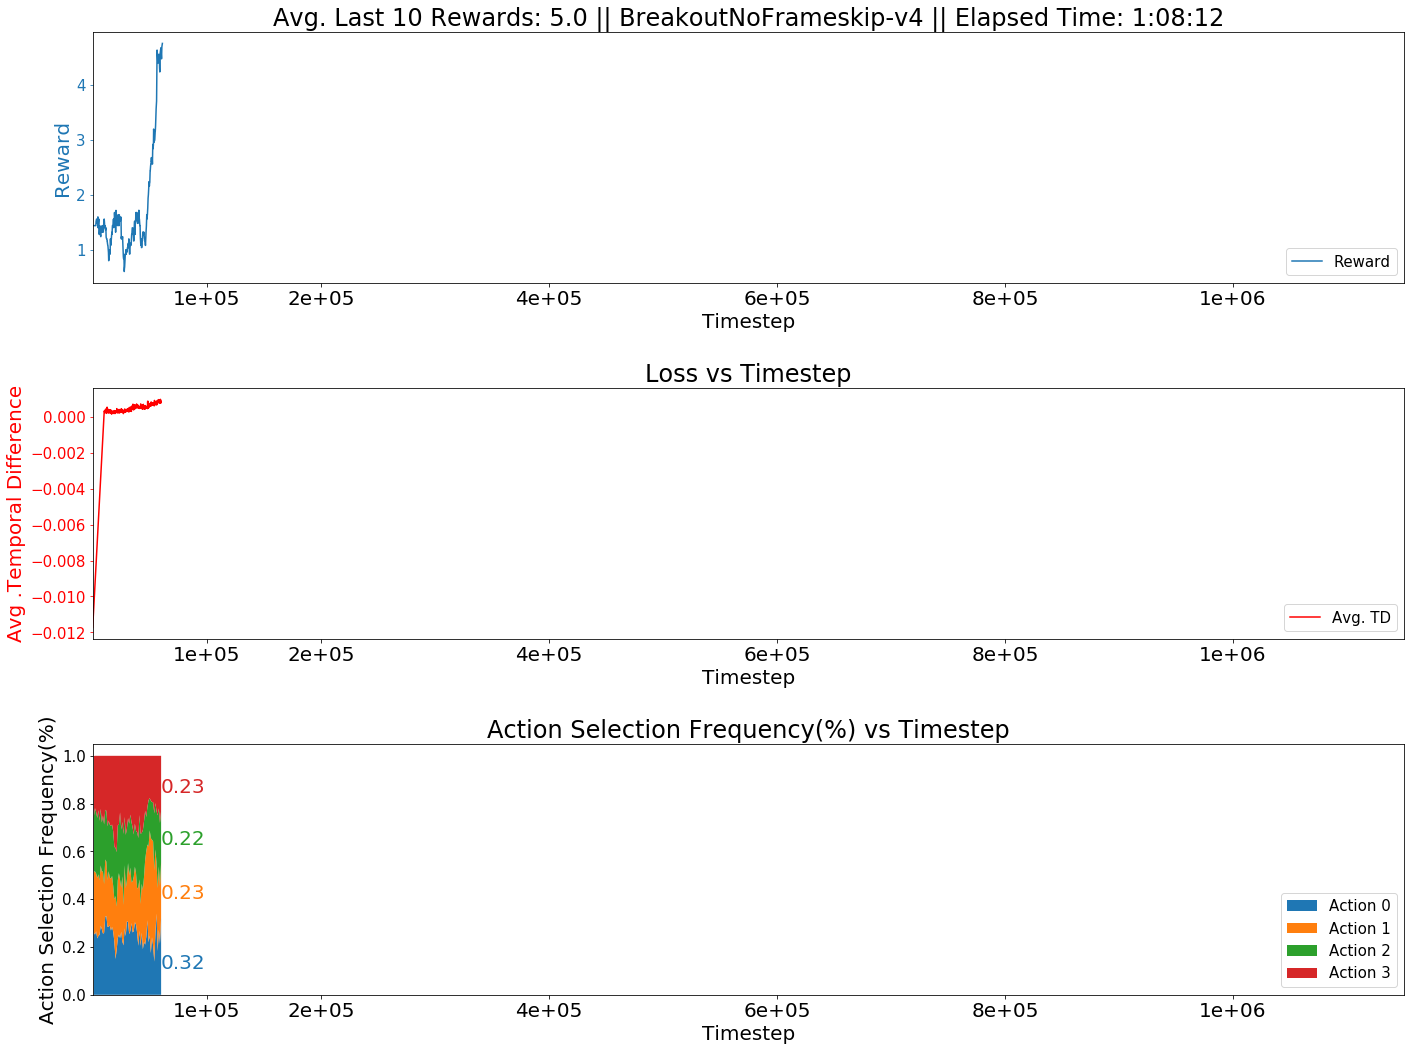

In [ ]:
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)
    model.save_action(action, frame_idx) #log action selection

    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation
    mask = np.random.binomial( n=1, p = config.BERNOULLI_P, size = config.NUM_HEADS )

    model.update(prev_observation, action, reward, observation, mask, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0

    if frame_idx % 1000 == 0:
        model.save_w()
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'dqn', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass

model.save_w()
env.close()
plot_all_data(log_dir, env_id, 'dqn', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)